Studio sugli aeroporti di NewYork

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('dataset/2012.csv')

In [34]:
filtered_df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

print(filtered_df.head())


      FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
0  2009-01-01       -4.0      -17.0    TUS  LAS     365.0      59.0
1  2009-01-01        7.0        0.0    ATL  BHM     134.0      28.0
2  2009-01-01       -6.0        2.0    SJU  BOS    1674.0     229.0
3  2009-01-01        0.0      -17.0    IAH  SNA    1347.0     187.0
4  2009-01-01       -5.0      -11.0    CMH  MCO     802.0     113.0


In [ ]:
ny_airports = ['JFK', 'LGA', 'EWR']
filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])
ny_flights_depatures = filtered_df[
    (filtered_df['ORIGIN'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]
ny_flights_arrivals = filtered_df[
    (filtered_df['DEST'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]

print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())

         FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
35323 2012-01-01       -6.0      -23.0    LGA  MKE     738.0     111.0
35331 2012-01-01       -5.0      -10.0    EWR  BWI     169.0      40.0
35357 2012-01-02      199.0      143.0    JFK  LAX    2475.0     318.0
35370 2012-01-02       -7.0       19.0    JFK  ORF     290.0      54.0
35390 2012-01-03       51.0       57.0    EWR  BQN    1585.0     208.0
         FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
35346 2012-01-01       32.0       28.0    HOU  EWR    1411.0     172.0
35351 2012-01-02       70.0       46.0    MCO  JFK     944.0     109.0
35353 2012-01-02       -4.0       -8.0    SFO  JFK    2586.0     297.0
35356 2012-01-02       27.0       10.0    PBI  JFK    1028.0     116.0
35382 2012-01-03       44.0       43.0    DSM  EWR    1017.0     135.0


C:\Users\aleda\AppData\Local\Temp\ipykernel_13124\4138963820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])


In [49]:
# identifichiamo la settimana

daily_departures = ny_flights_depatures.groupby('FL_DATE').size().reset_index(name='DEPARTURES')
daily_arrivals = ny_flights_arrivals.groupby('FL_DATE').size().reset_index(name='ARRIVALS')
daily_traffic = pd.merge(daily_departures, daily_arrivals, on='FL_DATE', how='outer').fillna(0)

daily_traffic['TOTAL_TRAFFIC'] = daily_traffic['DEPARTURES'] + daily_traffic['ARRIVALS']

print(daily_traffic.head())
print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())



     FL_DATE  DEPARTURES  ARRIVALS  TOTAL_TRAFFIC
0 2012-01-01         2.0       1.0            3.0
1 2012-01-02         2.0       3.0            5.0
2 2012-01-03         2.0       5.0            7.0
3 2012-01-04         2.0       0.0            2.0
4 2012-01-05         3.0       2.0            5.0
         FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME  WEEK
35323 2012-01-01       -6.0      -23.0    LGA  MKE     738.0     111.0    52
35331 2012-01-01       -5.0      -10.0    EWR  BWI     169.0      40.0    52
35357 2012-01-02      199.0      143.0    JFK  LAX    2475.0     318.0     1
35370 2012-01-02       -7.0       19.0    JFK  ORF     290.0      54.0     1
35390 2012-01-03       51.0       57.0    EWR  BQN    1585.0     208.0     1
         FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME  WEEK
35346 2012-01-01       32.0       28.0    HOU  EWR    1411.0     172.0    52
35351 2012-01-02       70.0       46.0    MCO  JFK     944.0     109.0     1
35353 2

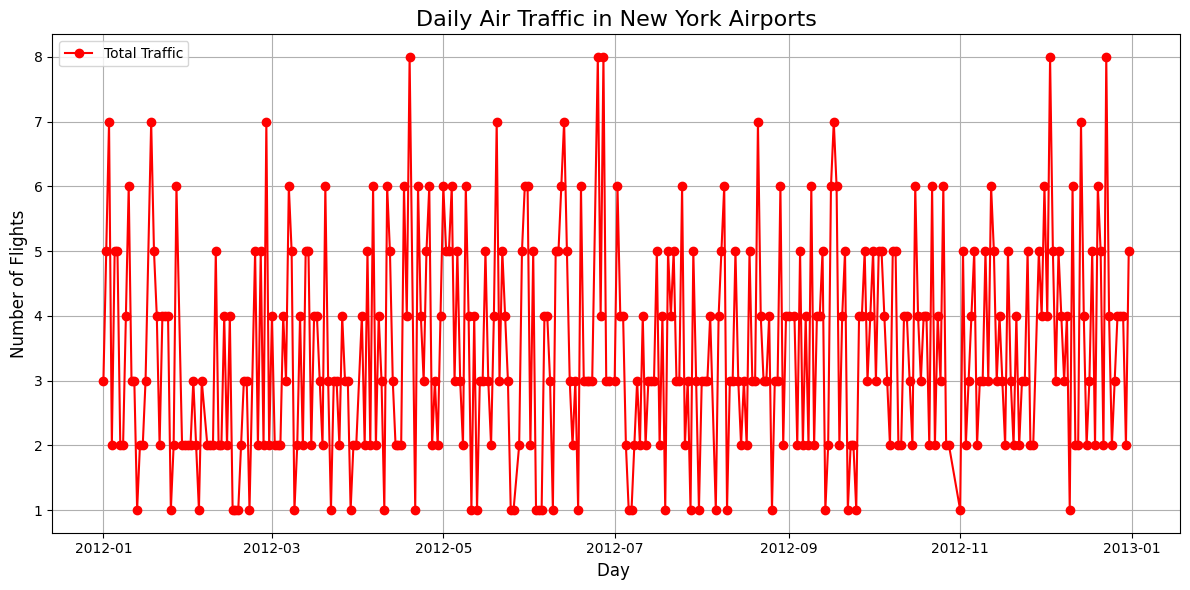

In [51]:
plt.figure(figsize=(12, 6))
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['DEPARTURES'], marker='o', linestyle='-', color='b', label='Departures')
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['ARRIVALS'], marker='o', linestyle='--', color='g', label='Arrivals')
plt.plot(daily_traffic['FL_DATE'], daily_traffic['TOTAL_TRAFFIC'], marker='o', linestyle='-', color='r', label='Total Traffic')
plt.title('Daily Air Traffic in New York Airports', fontsize=16)
plt.xlabel('Day ', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Studio sulle migliori rotte

In [3]:
rotte = pd.read_csv('dataset/best_route_flights.csv')

In [44]:
rotte.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,UA,133,SFO,LAX,900.0,858.0,-2.0,20.0,918.0,...,98.0,80.0,56.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,UA,817,SFO,LAX,1112.0,1104.0,-8.0,10.0,1114.0,...,98.0,78.0,54.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,UA,844,SFO,LAX,1536.0,1541.0,5.0,13.0,1554.0,...,88.0,75.0,55.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,UA,858,SFO,LAX,953.0,1006.0,13.0,16.0,1022.0,...,98.0,78.0,53.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,UA,888,SFO,LAX,1020.0,1014.0,-6.0,15.0,1029.0,...,98.0,75.0,53.0,337.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rotte = rotte[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

print(rotte.head())

      FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
0  2009-01-01       -2.0      -20.0    SFO  LAX     337.0      56.0
1  2009-01-01       -8.0      -28.0    SFO  LAX     337.0      54.0
2  2009-01-01        5.0       -8.0    SFO  LAX     337.0      55.0
3  2009-01-01       13.0       -7.0    SFO  LAX     337.0      53.0
4  2009-01-01       -6.0      -29.0    SFO  LAX     337.0      53.0


In [ ]:
rotte['FL_DATE']= pd.to_datetime(rotte['FL_DATE'])
daily_analysis = rotte.groupby("FL_DATE").agg(
    TOTAL_DEP_DELAY=("DEP_DELAY","sum"),
    TOTAL_ARR_DELAY=("ARR_DELAY", "sum"),
    AVG_AIR_TIME=("AIR_TIME", "mean"),  # Tempo medio di volo
).fillna(0) 

print(daily_analysis)

            TOTAL_DEP_DELAY  TOTAL_ARR_DELAY  AVG_AIR_TIME  TOTAL_DELAY
FL_DATE                                                                
2009-01-01            351.0             26.0     55.275862        377.0
2009-01-02           1714.0           1519.0     54.484848       3233.0
2009-01-03             36.0           -164.0     56.821429       -128.0
2009-01-04            270.0           -176.0     52.696970         94.0
2009-01-05            965.0            573.0     50.212121       1538.0
...                     ...              ...           ...          ...
2018-12-27            638.0            639.0     52.097561       1277.0
2018-12-28            422.0            420.0     53.975610        842.0
2018-12-29            151.0            -67.0     55.205882         84.0
2018-12-30            116.0             10.0     52.439024        126.0
2018-12-31            109.0           -121.0     52.656250        -12.0

[3590 rows x 4 columns]


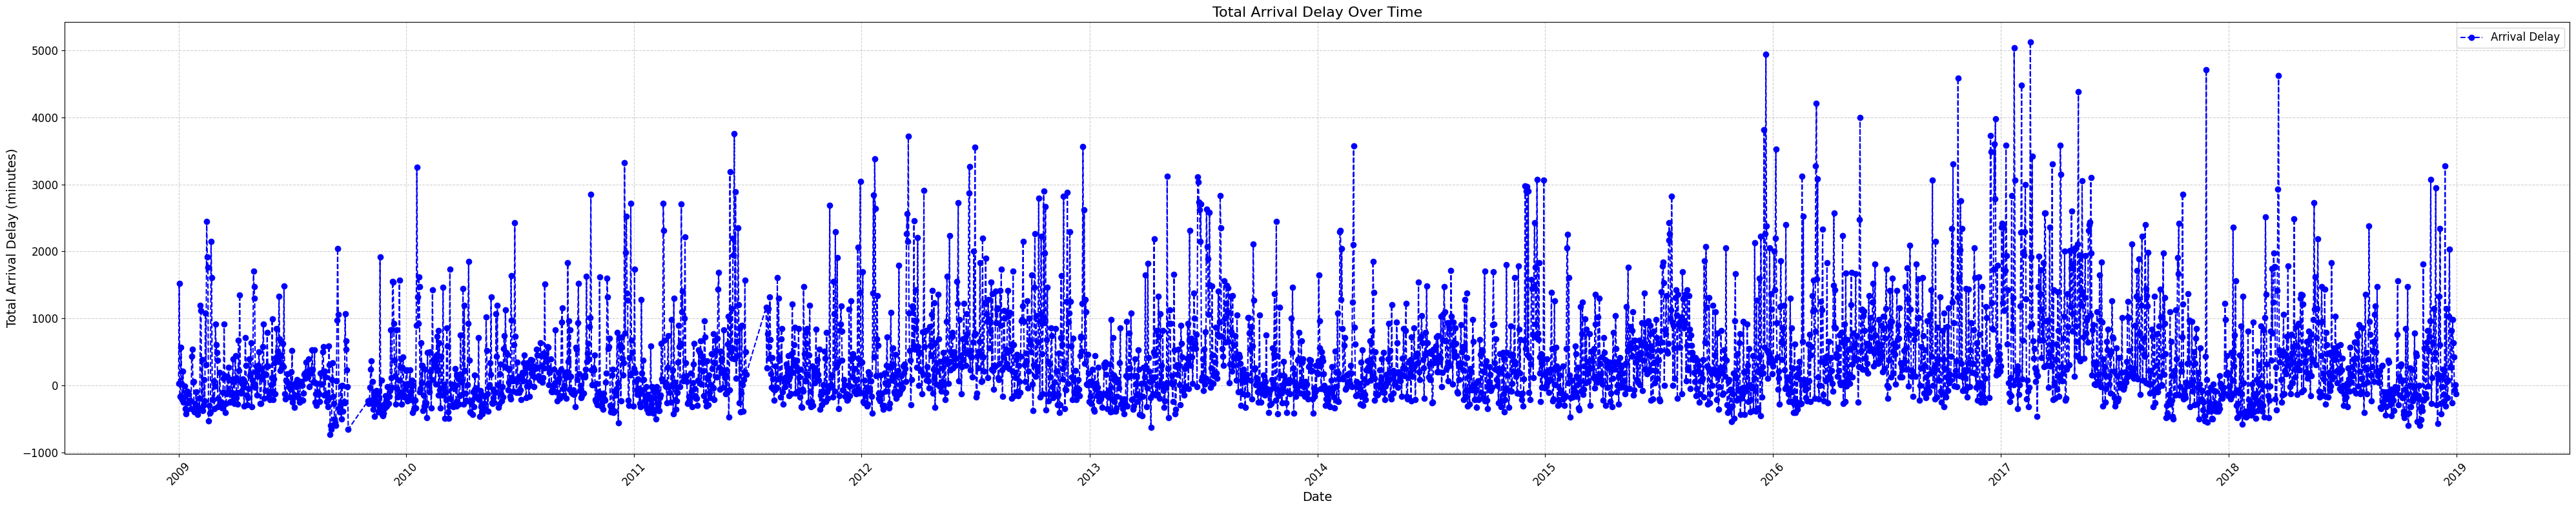

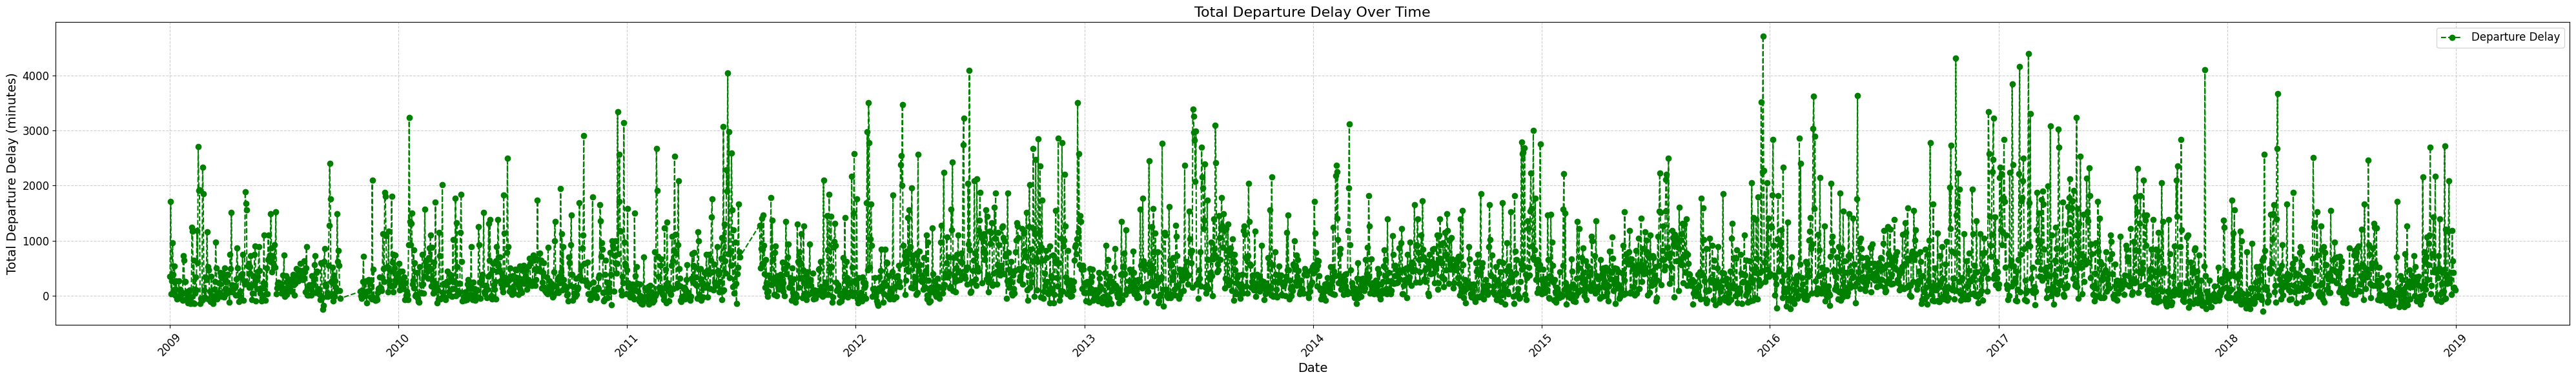

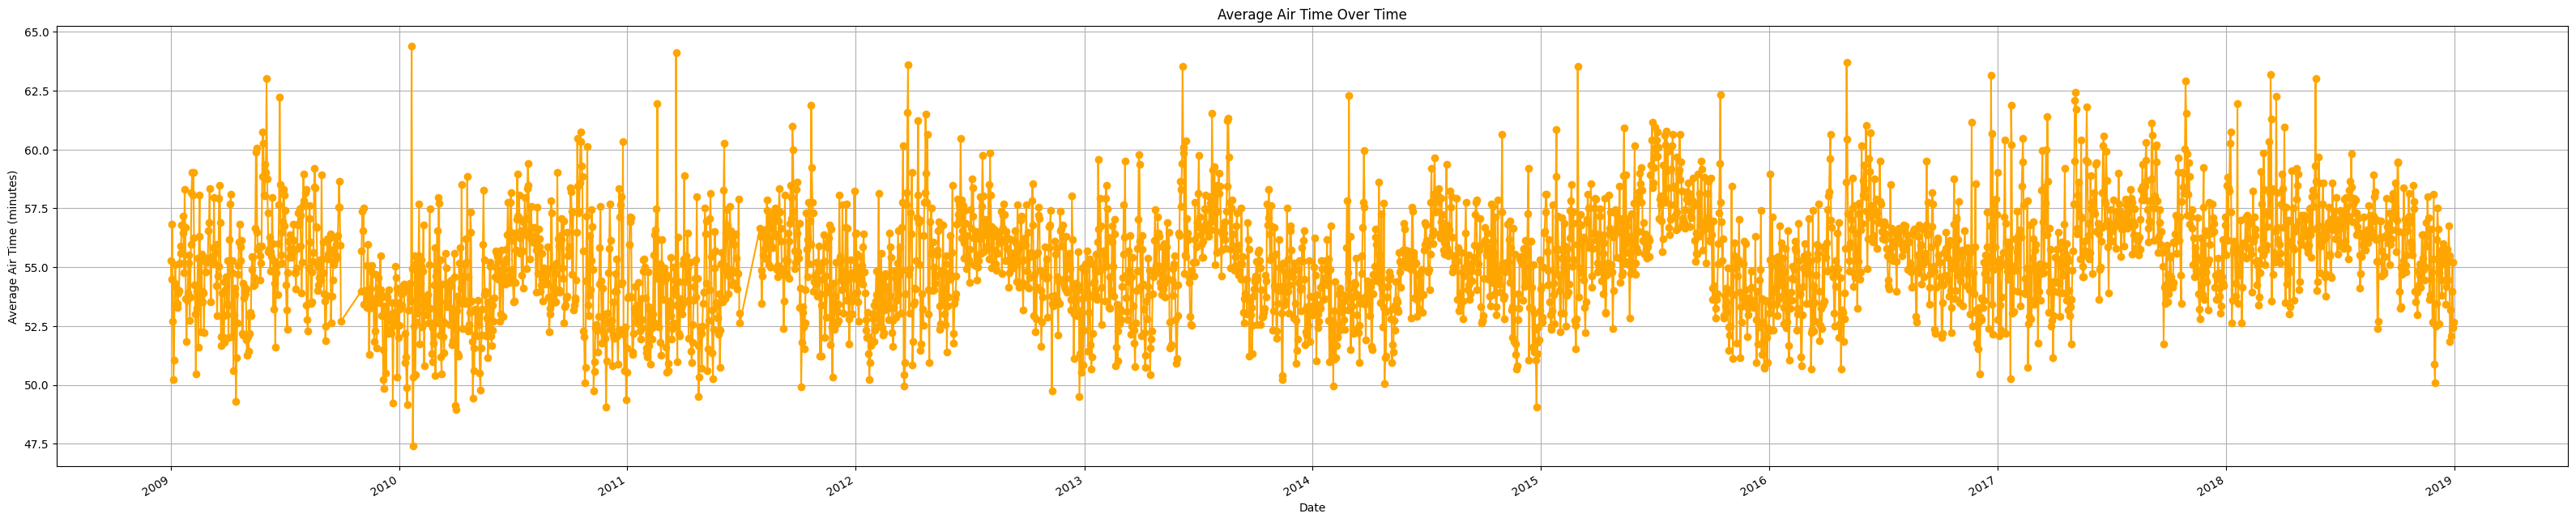

In [18]:

# Grafico del ritardo totale nel tempo (partenza e arrivo)
plt.figure(figsize=(40, 8))  # Dimensioni più grandi per maggiore chiarezza
plt.plot(
    daily_analysis.index, daily_analysis["TOTAL_ARR_DELAY"], 
    marker='o', linestyle='--', color='b', label='Arrival Delay'
)
plt.title("Total Arrival Delay Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Arrival Delay (minutes)", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico del ritardo totale in partenza nel tempo
plt.figure(figsize=(40, 6))  # Imposta una dimensione adeguata
plt.plot(
    daily_analysis.index, daily_analysis["TOTAL_DEP_DELAY"], 
    marker='o', linestyle='--', color='g', label='Departure Delay'
)
plt.title("Total Departure Delay Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Departure Delay (minutes)", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(40, 8))
daily_analysis["AVG_AIR_TIME"].plot(kind="line", title="Average Air Time Over Time", marker="o", color="orange")
plt.xlabel("Date")
plt.ylabel("Average Air Time (minutes)")
plt.grid()
plt.show() 
